In [1]:
# import traja
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import math
import scipy

In [2]:
# p ='/home/kate/Documents/navigation/dataset/2018.12.29/2018.12.29_2_Analysis.mat'
# f = scipy.io.loadmat(p)
# f['Analysis'] # ???

In [3]:
def open_file(fpath, show=False):
    df = pd.read_csv(fpath, sep=" ", header = None, names=['numb', 'time', 'x', 'y'])
    df = df.drop(df[df.time > 1755].index)
    if show:
        x = df['x'].values.tolist()
        y = df['y'].values.tolist()
        plot_tajectory(x, y)
    return df

def plot_tajectory(x, y):
    time_cmap = np.arange(0, len(x))
    plt.scatter(x, y, s=1, c=time_cmap)
    plt.plot(x, y, c='gray', alpha=0.4)
    plt.scatter(0, 0, marker='X', s=60, c='red')
    plt.colorbar()
    plt.show()

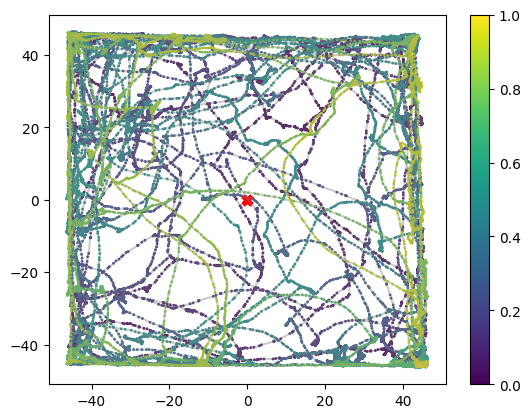

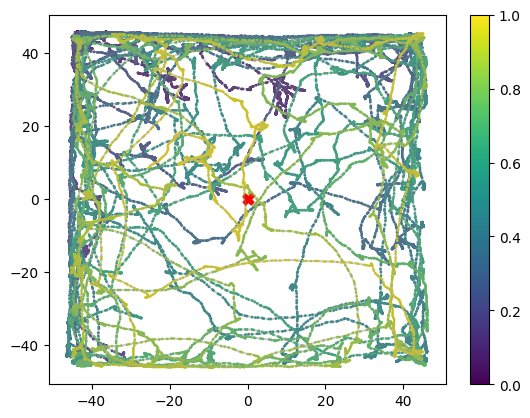

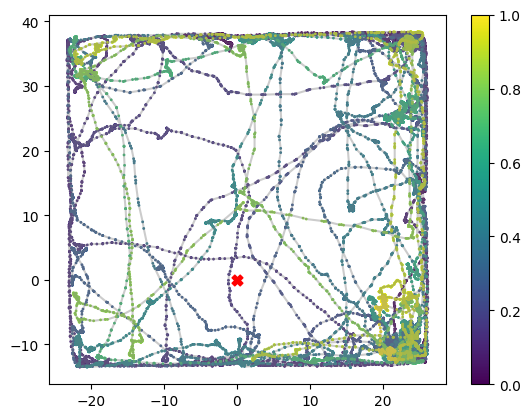

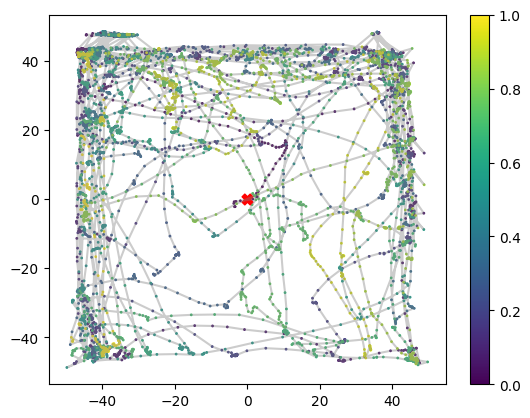

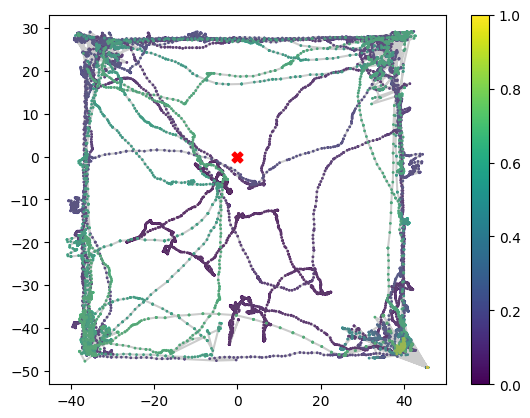

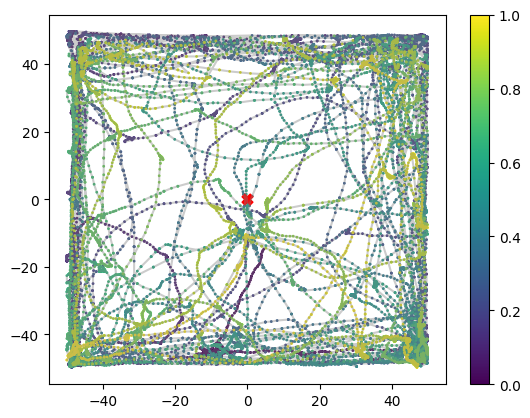

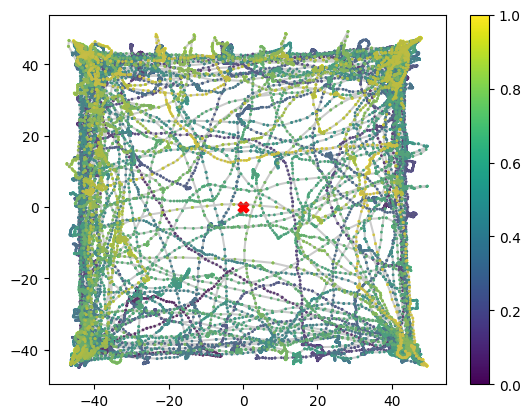

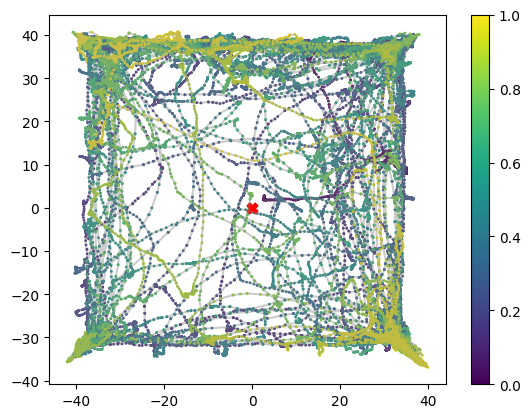

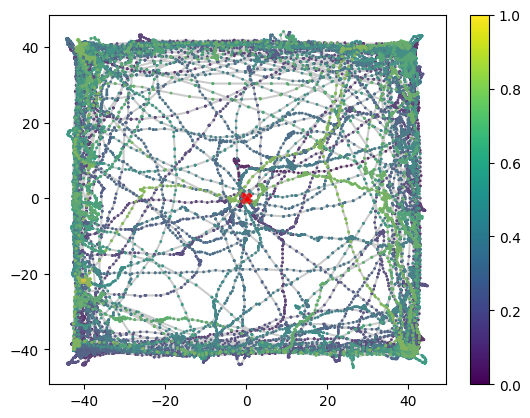

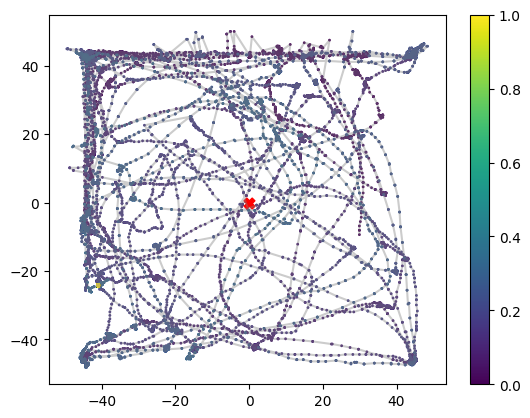

In [4]:
data_pathes = ['dataset/2018.12.08/after_floor_change/change_Trace.txt',
               'dataset/2018.12.08/before_floor_change/control_30min_Trace.txt',
               'dataset/2018.12.29/2018.12.29_2_Trace.txt',
               'dataset/2021. 01.20_metki_yes/sost_Trace.txt',
               'dataset/2021.01.19_metki_no/V_19.01.2021_Trace.txt',
               'dataset/2021.01.21_metki_yes/V_2_90_90_Trace.txt',
               'dataset/2021.02.27_metki_yes/V27.02.2021_Trace.txt',
               'dataset/2021.03.12_metki_yes_jump/V_2021_03_12_Trace.txt',
               'dataset/2021.06.16_1-2_days_metki_yes/2021.06.16_1-2_days_metki_yes/1_day_metki_yes/All_854_480_Trace.txt',
               'dataset/2021.06.16_1-2_days_metki_yes/2021.06.16_1-2_days_metki_yes/2_day_metki_yes/All_854_480_2day_Trace.txt',
               ]

# p = 'dataset/2018.12.29/2018.12.29_2_Trace.txt'
dfs = []
for p in data_pathes:
    dfs.append(open_file(p, show=True))

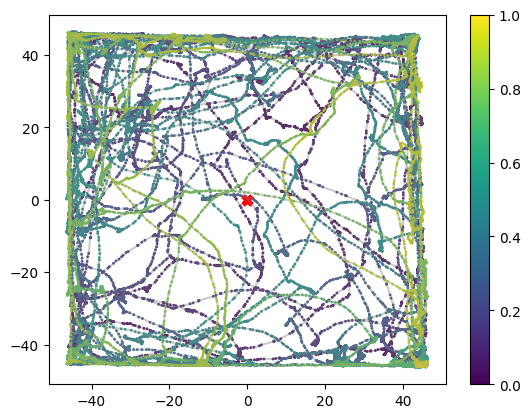

Derivative:


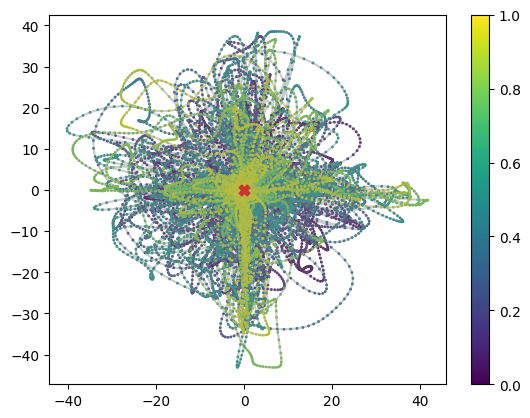

In [5]:
def add_filtered_V(df):

    dt = df['time'].diff()
    vx = df['x'].diff() / dt
    vy = df['y'].diff() / dt
    v = (vx**2 + vy**2)**0.5

    dt[0], vx[0], vy[0] = 0., 0., 0.
    v[0] = 0.
    df.insert(3, 'Vx', pd.Series(gaussian_filter1d(vx, 5)))
    df.insert(4, 'Vy', pd.Series(gaussian_filter1d(vy, 5)))
    df.insert(5, 'V', pd.Series(gaussian_filter1d(v, 5)))

    return(df)

ddf = dfs[0]
dff = add_filtered_V(ddf)
x = dff['x'].values.tolist()
y = dff['y'].values.tolist()
plot_tajectory(x, y)

print('Derivative:')
V_x = dff['Vx'].values.tolist()
V_y = dff['Vy'].values.tolist()
plot_tajectory(V_x, V_y)

In [6]:
import matplotlib.pyplot as plt
import os

def minmax_normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def build_vector_field(df, grid_size, title_name, lscale=0.17,
                       color_map='Reds',
                       unsmoothed_colors=False, save=False):
    eps = 0.1
    ind = range(0, len(df))
    df = df.reindex(ind)  # TODO: ??? # reset idx?

    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)  # TODO: why no epsilon for y?
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx'])
    dfvx = dfvx.unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy'])
    dfvy = dfvy.unstack()

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if np.isnan(dfvx.iloc[i, j]) or np.isnan(dfvy.iloc[i, j]):
                print(f'NaN in place: {i}, {j}')
                idx_list = np.array([[i-1, j-1], [i-1, j], [i-1, j+1],
                                     [i, j-1]  ,           [i, j+1],
                                     [i+1, j-1], [i+1, j], [i+1, j+1]])
                
                idx_to_drop = np.where((idx_list < 0) | (idx_list > grid_size-1))[0]
                print(f'Dropping indexes: {idx_to_drop}')
                dropping_mask = np.ones(idx_list.shape[0], dtype=bool)
                dropping_mask[idx_to_drop] = False
                idx_list = idx_list[dropping_mask]

                # TODO: by taking mean in corners we divide now by 8, but by 3
                # it is correct ????
                V_x_mean = np.nanmean(dfvx.iloc[idx_list[:, 0], idx_list[:, 1]])
                V_y_mean = np.nanmean(dfvy.iloc[idx_list[:, 0], idx_list[:, 1]])

                vector_column.append([binx[i], biny[j], V_x_mean, V_y_mean])

            else:
                vector_column.append([binx[i], biny[j], dfvx.iloc[i, j], dfvy.iloc[i, j]])
                
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)

    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]
    vectx_smoothed = gaussian_filter(vectx, sigma=1)
    vecty_smoothed = gaussian_filter(vecty, sigma=1)

    L_matrix = (vectx_smoothed**2 + vecty_smoothed**2)**0.5
    L_matrix_unsmoothed = (vectx**2 + vecty**2)**0.5 

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.axvline(0, c='black', alpha=0.2)
    ax.axhline(0, c='black', alpha=0.2)
    
    L = L_matrix_unsmoothed if unsmoothed_colors else L_matrix
    min_val, max_val = np.min(L), np.max(L)
    cmap = plt.cm.get_cmap(color_map)
    color_list = cmap(L)

    for i in range(grid_size):
        for j in range(grid_size):
            l = L_matrix[i, j]
            im1 = ax.quiver(vector_field_matrix[i, j, 0],
                            vector_field_matrix[i, j, 1],
                            vectx_smoothed[i, j], vecty_smoothed[i, j],
                            color=color_list[i, j], units='xy', pivot='middle',
                            scale=lscale*l, width=0.6)

    plt.title(f"Vector Field of Speed, {title_name}")

    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=min_val, vmax=max_val)
    plt.colorbar(sm, ax=ax)
    ax.set_facecolor('#CACACA')

    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images', title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()    

NaN in place: 7, 6
Dropping indexes: []


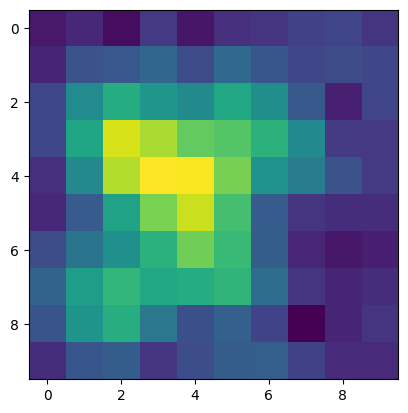

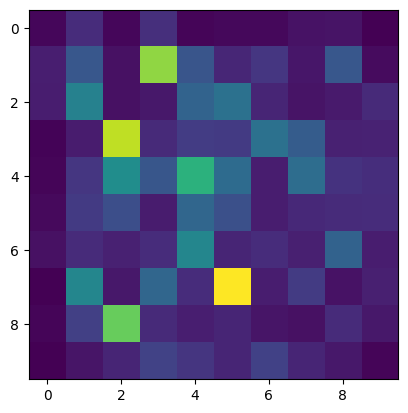

/tmp/ipykernel_6123/395392623.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color_map)


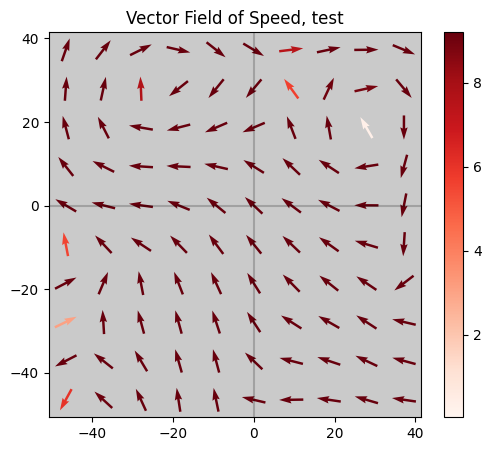

In [7]:
# dfa = dfs[2]
# buildVectorField(dff, 'dmk', 10)
build_vector_field(dff, grid_size=10, title_name='test',
                   lscale=0.17,
                   color_map='Reds',
                   unsmoothed_colors=False, save=False)

In [40]:
from statistics import mean

In [67]:
def killnan(z_v, n):
    for i in range(n):
        #kk = []
        for j in range(n):
            #если пустая клетка
            if np.isnan(z_v.iloc[i][j]):
                print('hu')
                aa=[]
                if i < n-2:
                    aa.append(z_v.iloc[i+1][j])
                    if j < n-2:
                        aa.append(z_v.iloc[i+1][j+1])
                    if j > 0:
                        aa.append(z_v.iloc[i+1][j-1])
                if j < n-2:
                    aa.append(z_v.iloc[i][j+1])
                    if i > 0:
                        aa.append(z_v.iloc[i-1][j+1])
                if i > 0:
                    aa.append(z_v.iloc[i-1][j])
                    if j > 0:
                        aa.append(z_v.iloc[i-1][j-1])
                if j > 0:
                    aa.append(z_v.iloc[i][j-1])
                #print(aa)
                #print(mean(aa))
                z_v.iloc[i][j] = mean(aa)
    return z_v


In [66]:
z_v1 = killnan(z_v,n)
#z_v1

hu
[20.410007406473103, 15.127011989817367, 11.105187910853168, 10.933995806964676, 14.157919637039939, 17.56367969866718, 24.51034814113543, 11.78340233622859]
15.698944115897431


In [209]:
def changeVect(vx, vy, mea, st):
    vb = ((vx ** 2) + (vy ** 2)) ** 0.5
    cosa = vx / vb
    sina = vy / vb
    vn = abs((vb - mea) / st)
    vx = vn * cosa
    vy = vn * sina
    return vx, vy

In [202]:
names

['tr4', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92', 'tr1', 'tr2']

1.2806120875017215
2.100860466474526
2.6633296940737883
2.5152861912515196
1.5284707217395823
0.7670266133425399
0.690887464002778
0.6233469542194747
0.32194410632652937
0.08606488497038617
2.1876488262800247
3.7120569006458326
3.666734397086584
2.1537991349978385
1.1200460250220188
1.1512241692451621
1.0492322668178617
0.6499621692102912
0.4563623239069337
0.36071477625261134
3.4002985491097
6.157531099087383
5.83762393595264
3.350940558178984
1.3815941915153986
1.7993517754790684
2.1911242890235423
1.6555583203907573
1.1614026352837488
0.8791568575225035
3.624691795703729
7.1687622071864965
7.46426316528291
5.540521710903749
3.4499063705322373
3.4295696863396152
3.4532595497105643
2.6285099236818867
1.7614147195472698
1.1628318626905385
1.6829623941743088
5.161168265334156
6.64412233386783
5.966282685418934
4.395040252082201
3.844616304608466
2.8847978864464827
2.0640894002983647
1.6872020694696708
1.0897820949236714
1.455323853442337
2.2689392777570987
4.904533247277407
4.8320434600

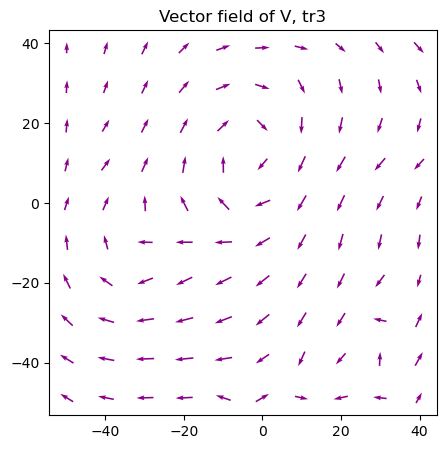

0.6518206349943929
0.5426571459183704
0.7699091838103834
1.0861461002737418
1.391165041479786
1.1536019076792592
1.1397644703209513
1.4180603410645485
1.0847307426959751
0.9317262789843758
0.9267177434719792
0.13641325018371836
0.4118133537500033
1.7531316490105038
3.51498588853744
3.124815641602295
2.041285451268805
1.8441303000917402
1.0380358736804858
1.223207397495104
1.3687854476595083
0.5627917054974408
1.5527633792875226
4.553439811955417
8.740715010704132
8.403373004071621
5.884326614480748
3.759870582344862
1.6952059524101124
1.8960228021570629
1.2141925285730009
0.8138531819618127
1.8736402906107845
4.888841206742375
9.699286293541327
10.12790547511107
8.188112100396456
5.967286960964776
3.4463517592059887
2.0275518026679458
1.1159671757399534
0.6668319949717897
1.9094194171389571
2.684881251862943
5.018732736568906
6.059115634039858
6.428384078837585
6.087685780839883
4.499593294343541
2.1056478215232746
1.687416032371713
1.1556340442991684
2.635387852443078
2.98880536806845

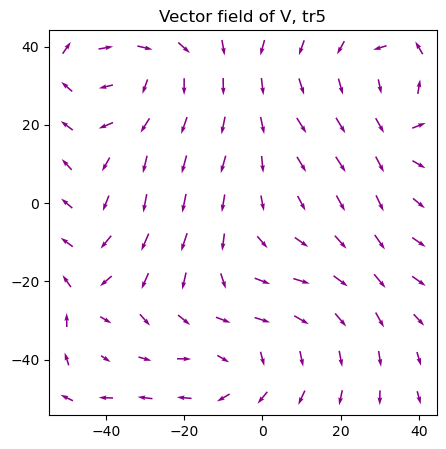

1.1175677736232903
1.3256864118465896
1.4798438705238919
1.6860164603872083
1.6664924602764128
1.217690767389565
0.9990199775921716
0.9868695403707108
0.9426299623025279
0.47490080006772445
2.6195105330123356
2.210076864414071
1.1885278452882497
1.3269944644873344
1.905165306885767
1.0590209594728421
0.6732056492637493
1.0677445458142298
1.324832559094554
0.5976358353543915
4.717062951705933
3.62183860111447
0.9191551753732388
2.5609862487373762
4.2114899036760125
3.1201331867951447
1.479765461474965
1.4852204000075346
2.05861363887109
1.1605286708422362
5.996590505420871
4.944613403740713
1.4994103210965768
2.9578420609066196
5.44365474740924
5.004051258318142
2.757974437089291
2.0820539961041136
3.1610197976850514
2.3634530556194786
6.664028602018535
6.247840791110898
3.3861196989788866
1.1100257102432107
4.476219585504447
5.5471875338322825
4.203522722455442
3.4969188791068815
4.3045923742477985
3.7375683797047485
6.916548710430592
6.996481918060246
4.542727193018094
1.0635397133784

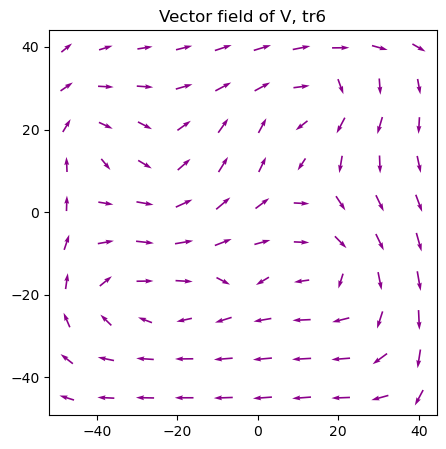

1.393306655354168
1.8749823311641767
3.6255790000168266
4.740929749879322
4.354155801254298
3.5187735863093357
2.342073248514655
1.5264624944253185
1.0237150935136636
0.5528978373548564
2.1004342537940848
0.7479803718988699
1.3467527412517177
1.97971260508105
2.356350817664833
2.4671338176678748
1.5841509047892282
0.8018337543113682
0.41877346739482946
0.23548375427950852
2.821002362202903
0.743122703442675
1.5132470031796537
1.9933633755512554
1.9380521023110038
2.8254449732607143
2.2825271262491613
1.3727760296095228
0.7126435091634831
0.4092778926656151
3.4840783558117474
1.937143639612509
1.3126276309213387
1.4081518305320357
1.1789274020767573
1.9437180212527116
1.8829216643174713
1.629982857848385
1.2621538134461467
0.7816985232349895
4.3848714382078535
3.0249434239884
2.530901922942368
1.5854281957596965
1.156395980142566
1.2952759332125303
1.3616309890910077
0.2330582877199084
0.6843978853443736
0.7608460172013474
4.709433345304867
2.8343123376947594
2.0163010820735647
1.521752

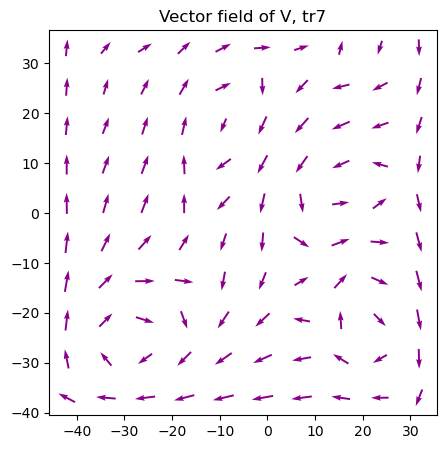

3.290011591746127
3.806347204853571
4.916268742888677
5.861856384500376
5.464195761427784
5.417386202274098
5.71713723614057
5.867655680372363
4.984877914408697
3.758128217238561
6.598649664147902
7.553473182042274
9.170653840548542
9.088916709231187
6.2066118103751
1.7673241385668683
2.532124189511749
4.9549368806319505
6.001303326047501
6.46692745274521
9.885475502133446
11.884918620662111
14.037485547260832
12.404677103423618
7.554417196445532
3.410338380318072
5.673459548153258
7.2192831786902865
9.153956497148283
11.214926635809292
10.327435147975883
12.514804218048926
13.635496312666374
10.61273313716831
5.975008232947961
3.8261443866601743
6.240913086819298
8.103834176555456
11.558278809670835
14.709753956235216
9.92757528496139
11.463000446028781
11.015280505826427
7.142888306983901
3.6444871845871813
3.4717302588974364
5.807159355458399
8.62051375625628
12.530631098781834
14.746211049898614
9.974698746769876
11.731402057696455
11.147650556017016
6.8385618618503985
3.4417831630

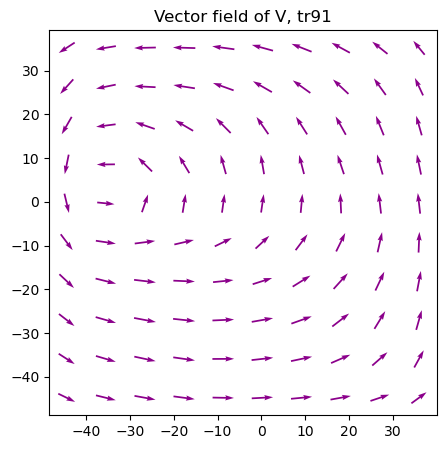

2.637572837818093
4.045496469530174
5.365974111698796
5.879572200982634
5.753349547466573
5.132056833168073
3.949857555625876
3.344128252853289
2.2677441234638924
0.7846660643336416
3.824067001459422
5.02497460412278
6.390475555702353
5.885366625108459
5.933313305919462
6.931684965735634
6.421315019501168
5.271813642362149
3.0834448904475393
1.139125318714215
6.138799694727857
6.175585594239954
5.8554919483668835
2.1648294854778767
5.116789087826851
9.78013840109115
9.666401548677412
6.440272196130181
3.209365547277106
1.9571703113620154
10.046883226713033
8.669180758661444
7.650792788195743
7.143994046090636
7.1571406232199095
10.254022464892374
10.409074714227376
5.868227593675974
2.8106616156718176
2.6648732988124744
13.017857581600667
10.114188013099032
9.528071008584524
11.896996813027025
11.26806395165368
9.73763105428257
8.289526405300977
4.244124884279418
2.5825556813128325
3.8170411587431494
12.542321253758823
10.794165238585567
10.858163745209515
11.36669080066412
9.308080184

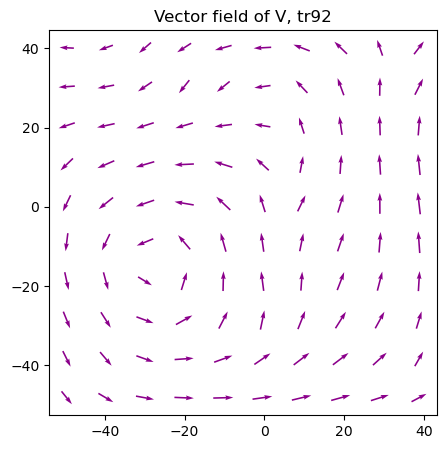

0.6636968744161515
1.1122623712393882
0.30560382599319386
1.5560810678152066
0.6008431166292816
1.3033640263108917
1.4587407566481037
1.8231796657883952
1.9756508940553705
1.4409986975366373
1.0464334793223355
2.4671783234441405
2.5418553686148035
3.059623452230904
2.1443677499028957
3.1774857605972238
2.47173067746885
1.9626493906118543
2.135216283577677
1.990171464186118
2.038023388931472
4.529325464032509
5.730734171160911
4.843596837855195
4.387839668956518
5.499619180368324
4.559775111260339
2.589624171429487
0.7985269207453244
1.9255327756817289
2.006469350423351
5.451359042501798
8.655850166298938
8.019741707248064
6.995698625829395
6.732297725790448
5.922847818476516
4.455630769880662
1.6394497080703334
1.525575204898542
1.303400659698694
4.374659494130212
8.182827987926794
9.206070790985098
9.109464604950592
7.33098951025818
4.699844068469612
3.885680383818135
2.308095637512974
1.5974029154056766
1.1803079664675613
2.771217558788249
5.363863576809975
7.3549229222089405
8.45072

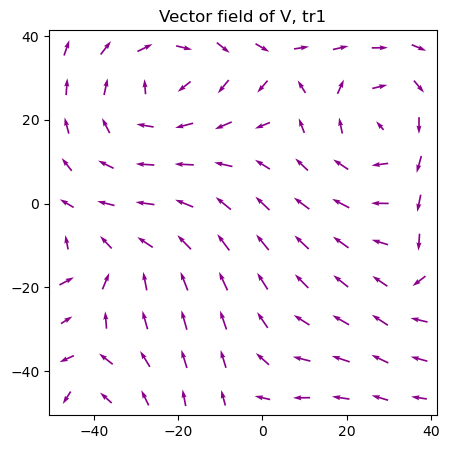

0.47185957242139126
1.2173879386690638
2.2007110743333285
3.0730459698299475
3.928883139720287
4.08885904717158
2.8346449817647414
1.2573116640173811
0.5955129062619157
0.19114136251552702
0.92818265515397
1.8631165632115252
3.369213119737957
5.838243061289481
8.744991550074987
8.704772566962815
5.388225942019844
1.8559989509859092
0.6262603508054266
0.17786565216067213
0.6667509874117735
0.6571767810028715
1.4228940170588422
4.885470851909515
8.976916627094583
8.1819021219312
3.9876058119284155
0.8765420657481396
0.7516697886683844
0.6000157019903749
0.3095674623356552
1.4668889474501088
1.9533844598824897
0.7314243771082132
3.5568229726231175
3.165844760721711
3.4444130163991473
3.1460632387602776
1.8386976319665271
1.2615724357102915
0.7203179981266842
1.6691991313713863
2.1669495436762185
1.5942130802628862
1.3862440616666782
2.9266718384554453
5.736023796233974
5.922202690433564
3.845573757537345
2.020949578216642
0.689464692069509
1.4426572064790257
1.9756589760340506
1.993174169

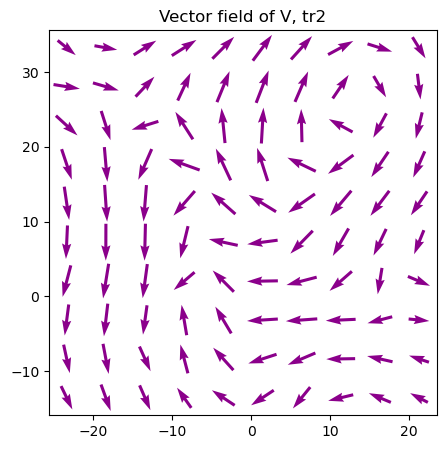

In [212]:
for i in range(1,len(dfs)):
    buildVectorField(dfs[i], names[i], 10)

hu
hu
hu
hu
hu
binxi -49.819
binxi -39.8552
binxi -29.8914
binxi -19.927599999999998
binxi -9.963799999999999
binxi 0.0
binxi 9.963800000000006
binxi 19.927599999999998
binxi 29.891400000000004
binxi 39.85520000000001
[[-49.819  -49.819  -49.819  -49.819  -49.819  -49.819  -49.819  -49.819
  -49.819  -49.819 ]
 [-39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552
  -39.8552 -39.8552]
 [-29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914
  -29.8914 -29.8914]
 [-19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276
  -19.9276 -19.9276]
 [ -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638
   -9.9638  -9.9638]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  9.9638   9.9638   9.9638   9.9638   9.9638   9.9638   9.9638   9.9638
    9.9638   9.9638]
 [ 19.9276  19.9276  19.9276  19.9276  19.9276  19.9276  19.9276  19.9276
   19.9276  19.9276]
 [ 29.8914  29.8914  29.891

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


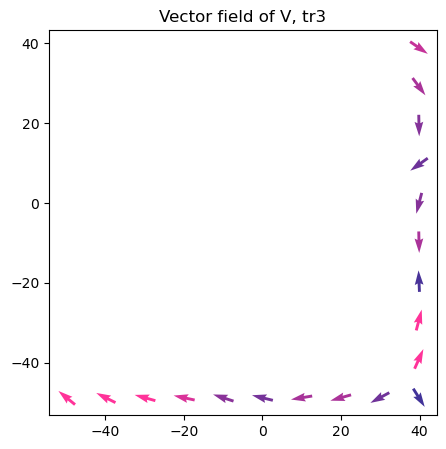

binxi -50.013
binxi -40.0104
binxi -30.0078
binxi -20.005200000000002
binxi -10.002600000000001
binxi 0.0
binxi 10.002599999999994
binxi 20.005199999999995
binxi 30.007799999999996
binxi 40.0104
[[-50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013
  -50.013  -50.013 ]
 [-40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104
  -40.0104 -40.0104]
 [-30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078
  -30.0078 -30.0078]
 [-20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052
  -20.0052 -20.0052]
 [-10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026
  -10.0026 -10.0026]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [ 10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026
   10.0026  10.0026]
 [ 20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052
   20.0052  20.0052]
 [ 30.0078  30.0078  30.0078  30.0078  30.0078  30

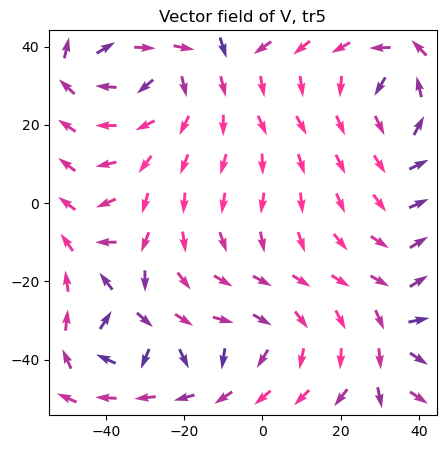

binxi -47.496
binxi -37.7693
binxi -28.042600000000004
binxi -18.315900000000006
binxi -8.589200000000005
binxi 1.1374999999999957
binxi 10.86419999999999
binxi 20.590899999999998
binxi 30.31759999999999
binxi 40.044299999999986
[[-47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496
  -47.496  -47.496 ]
 [-37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693
  -37.7693 -37.7693]
 [-28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426
  -28.0426 -28.0426]
 [-18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159
  -18.3159 -18.3159]
 [ -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892
   -8.5892  -8.5892]
 [  1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375
    1.1375   1.1375]
 [ 10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642
   10.8642  10.8642]
 [ 20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909
   20.5909  20.5909]
 [ 30.3176  

0.8270922382524452
1-l 0.17290776174755484
(0.8270922382524452, 0, 0.5, 0.8)
0.867631796120327
1-l 0.13236820387967296
(0.867631796120327, 0, 0.5, 0.8)


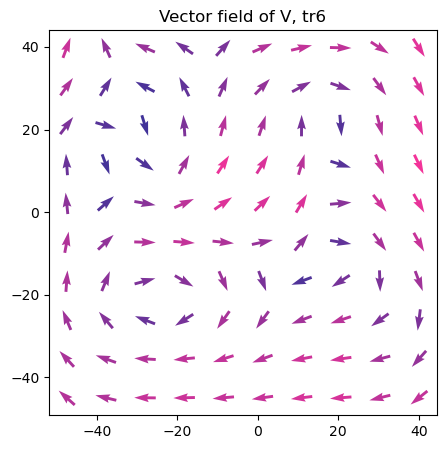

binxi -42.108000000000004
binxi -33.89790000000001
binxi -25.687800000000003
binxi -17.477700000000002
binxi -9.267600000000002
binxi -1.0575000000000045
binxi 7.1526
binxi 15.362700000000004
binxi 23.5728
binxi 31.782899999999998
[[-42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108
  -42.108  -42.108 ]
 [-33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979
  -33.8979 -33.8979]
 [-25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878
  -25.6878 -25.6878]
 [-17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777
  -17.4777 -17.4777]
 [ -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676
   -9.2676  -9.2676]
 [ -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575
   -1.0575  -1.0575]
 [  7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526
    7.1526   7.1526]
 [ 15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627
   15.3627  15.3627]
 [ 23.5728

0.8810357837937819
1-l 0.11896421620621811
(0.8810357837937819, 0, 0.5, 0.8)


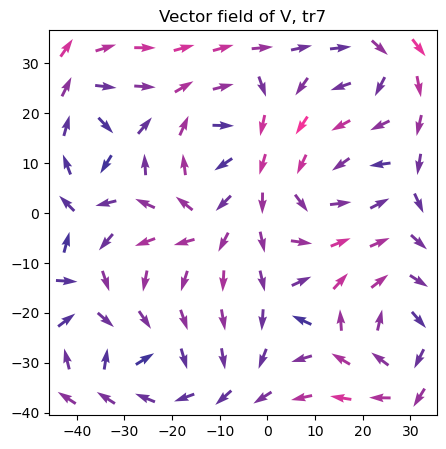

binxi -44.432
binxi -35.499700000000004
binxi -26.5674
binxi -17.635099999999998
binxi -8.702799999999996
binxi 0.2295000000000016
binxi 9.161800000000007
binxi 18.09410000000001
binxi 27.02640000000001
binxi 35.95870000000001
[[-44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432
  -44.432  -44.432 ]
 [-35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997
  -35.4997 -35.4997]
 [-26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674
  -26.5674 -26.5674]
 [-17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351
  -17.6351 -17.6351]
 [ -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028
   -8.7028  -8.7028]
 [  0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295
    0.2295   0.2295]
 [  9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618
    9.1618   9.1618]
 [ 18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941
   18.0941  18.0941]
 [ 27.0264  27

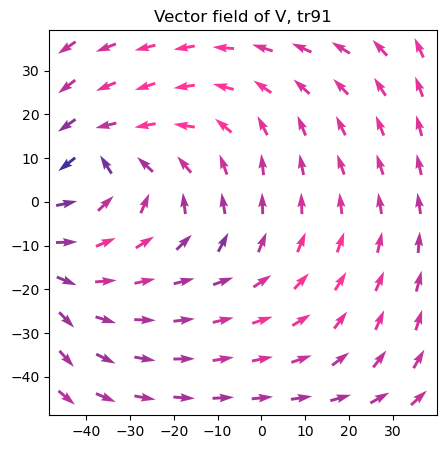

hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
binxi -49.543
binxi -39.7358
binxi -29.9286
binxi -20.1214
binxi -10.3142
binxi -0.5069999999999979
binxi 9.300199999999997
binxi 19.107400000000005
binxi 28.9146
binxi 38.721799999999995
[[-49.543  -49.543  -49.543  -49.543  -49.543  -49.543  -49.543  -49.543
  -49.543  -49.543 ]
 [-39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358
  -39.7358 -39.7358]
 [-29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286
  -29.9286 -29.9286]
 [-20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214
  -20.1214 -20.1214]
 [-10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142
  -10.3142 -10.3142]
 [ -0.507   -0.507   -0.507   -0.507   -0.507   -0.507   -0.507   -0.507
   -0.507   -0.507 ]
 [  9.3002   9.3002   9.3002   9.3002   9.3002   9.3002   9.3002   9.3002
    9.3002   9.3002]
 [ 19.1074  19.1074  19.1074  19.1074  19.1074  19.1074  19.1074  19.1074
   19.1074  19.1074]
 [ 28.9146  28.914

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


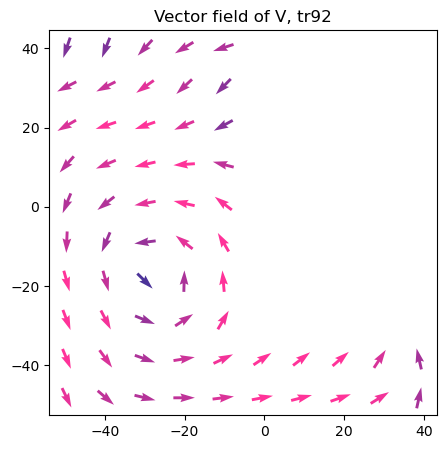

hu
hu
hu
hu
binxi -46.433
binxi -37.1464
binxi -27.8598
binxi -18.5732
binxi -9.2866
binxi 0.0
binxi 9.2866
binxi 18.573200000000007
binxi 27.8598
binxi 37.14639999999999
[[-46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433
  -46.433  -46.433 ]
 [-37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464
  -37.1464 -37.1464]
 [-27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598
  -27.8598 -27.8598]
 [-18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732
  -18.5732 -18.5732]
 [ -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866
   -9.2866  -9.2866]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866
    9.2866   9.2866]
 [ 18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732
   18.5732  18.5732]
 [ 27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598


0.3228607795319771
1-l 0.6771392204680229
(0.3228607795319771, 0, 0.5, 0.8)
0.5211642174388604
1-l 0.47883578256113957
(0.5211642174388604, 0, 0.5, 0.8)
0.7427390063614722
1-l 0.25726099363852784
(0.7427390063614722, 0, 0.5, 0.8)


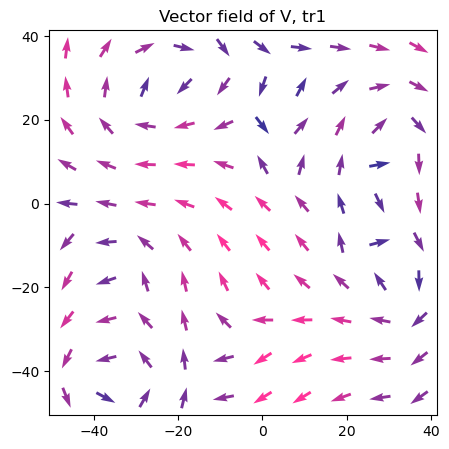

hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
binxi -23.365000000000002
binxi -18.407600000000002
binxi -13.4502
binxi -8.492799999999999
binxi -3.535399999999999
binxi 1.4220000000000006
binxi 6.379400000000004
binxi 11.336800000000004
binxi 16.294200000000004
binxi 21.251600000000003
[[-23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365
  -23.365  -23.365 ]
 [-18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076
  -18.4076 -18.4076]
 [-13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502
  -13.4502 -13.4502]
 [ -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928
   -8.4928  -8.4928]
 [ -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354
   -3.5354  -3.5354]
 [  1.422    1.422    1.422    1.422    1.422    1.422    1.422    1.422
    1.422    1.422 ]
 [  6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794
    6.3794   6.3794]
 [ 11.3368  11.3368  11.3368  11.3368  11.336

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


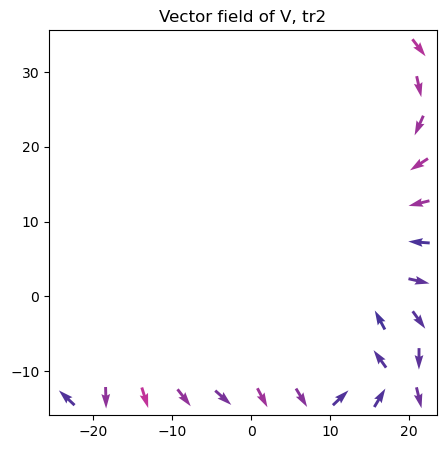

In [211]:
for i in range(1,len(dfs)):
    plotVectField(dfs[i], names[i], 10)

# новач функция plotvectfield

In [210]:
n=10
df = dfs[4]
name = names[4]
def plotVectField(df, name, n):
    ind = range(0, len(df))
    df = df.reindex(ind)   
    binx = np.linspace(df["x"].min() - 0.1, df["x"].max() + 0.1, n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).mean()

    z_v = pd.DataFrame(dfn.loc[:, 'V'])
    z_v = z_v.unstack()

    dfstd = df.groupby([x_cut, y_cut]).std()
    z_std = pd.DataFrame(dfstd.loc[:, 'V'])
    z_std = z_std.unstack()

    dfvx = pd.DataFrame(dfn.loc[:, 'Vx'])
    dfvx = dfvx.unstack()
    #print(dfvx)
    dfvy = pd.DataFrame(dfn.loc[:, 'Vy'])
    dfvy = dfvy.unstack()

    z_v = killnan(z_v,n)
    z_std = killnan(z_std,n)
    dfvx = killnan(dfvx,n)
    dfvy = killnan(dfvy,n)
    
    forVect = []
    for i in range(n):
        kk = []
        for j in range(n):
            vx = dfvx.iloc[i][j]
            vy = dfvy.iloc[i][j]
            mea = z_v.iloc[i][j]
            st = z_std.iloc[i][j]
            vx, vy = changeVect(vx, vy, mea, st)
            kk.append([binx[i],biny[j],vx,vy])
        print('binxi',binx[i])
        forVect.append(kk)
    Vectors = np.array(forVect)
    #print(pd.DataFrame(Vectors))
    print(Vectors[:, :, 0])
    #print(Vectors.shape)
    plt.figure(figsize=(5,5))
    vectx = Vectors[:,:,2]
    vecty = Vectors[:,:,3]
    vectx = gaussian_filter(vectx, sigma=1)
    vecty = gaussian_filter(vecty, sigma=1)
    for i in range(n):
        for j in range(n):
            l = pow((pow(vectx[i][j], 2) + pow(vecty[i][j], 2)), 0.5)
            print(l)
            #print(j[2], j[3], l)
            #plt.quiver(j[0], j[1], j[2], j[3], color='darkmagenta', units='xy',pivot='middle',scale=l/3.5, width=0.3)
            print('1-l', 1-l)
            q = l
            if q > 1:
                q = 1
                print('>1', q)
            c = (q, 0, 0.5, 0.8)
            print(c)
            plt.quiver(Vectors[i][j][0], Vectors[i][j][1], vectx[i][j], vecty[i][j], color=c, units='xy',pivot='middle')
            #print(l)
    # Show plot with grid
    #plt.grid()
    plt.title("Vector field of V, " + name)
    #plt.savefig('C:\\Users\\Lenovo\\1navigation\\vectFields\\filtered\\' + name + 'NewVelocityField.png')
    plt.show()
    

n=10
df = dfs[3]
name = names[3]
if True:
    ind = range(0, len(df))
    df = df.reindex(ind)   
    binx = np.linspace(df["x"].min() - 0.1, df["x"].max() + 0.1, n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).mean()
    z_v = pd.DataFrame(dfn.loc[:, 'V'])
    z_v = z_v.unstack()
    dfstd = df.groupby([x_cut, y_cut]).std()
    z_std = pd.DataFrame(dfstd.loc[:, 'V'])
    z_std = z_std.unstack()
    dfvx = pd.DataFrame(dfn.loc[:, 'Vx'])
    dfvx = dfvx.unstack()
    #print(dfvx)
    dfvy = pd.DataFrame(dfn.loc[:, 'Vy'])
    dfvy = dfvy.unstack()
    forVect = []
    for i in range(n):
        kk = []
        for j in range(n):
            kk.append([binx[i],biny[j],dfvx.iloc[i][j],dfvy.iloc[i][j]])
        forVect.append(kk)
    Vectors = np.array(forVect)
    print(Vectors.shape)
    plt.figure(figsize=(12,12))
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in Vectors:
        for j in i:
            l = pow((pow(j[2], 2) + pow(j[3], 2)), 0.5)
            print(j[2], j[3], l)
            #plt.quiver(j[0], j[1], j[2], j[3], color='darkmagenta', units='xy', scale=l/3.5, width=0.3)
            plt.quiver(j[0], j[1], j[2], j[3], color='darkmagenta', units='xy', width=0.3)
    # Show plot with grid
    #plt.grid()
    plt.title("Vector field of V, " + name)
    #plt.savefig('C:\\Users\\Lenovo\\1navigation\\vectFields\\' + name + 'NewVelocityField.png')
    plt.show()

hu
hu
hu
hu
hu
binxi -49.819
binxi -39.8552
binxi -29.8914
binxi -19.927599999999998
binxi -9.963799999999999
binxi 0.0
binxi 9.963800000000006
binxi 19.927599999999998
binxi 29.891400000000004
binxi 39.85520000000001
[[-49.819  -49.819  -49.819  -49.819  -49.819  -49.819  -49.819  -49.819
  -49.819  -49.819 ]
 [-39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552 -39.8552
  -39.8552 -39.8552]
 [-29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914 -29.8914
  -29.8914 -29.8914]
 [-19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276 -19.9276
  -19.9276 -19.9276]
 [ -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638  -9.9638
   -9.9638  -9.9638]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  9.9638   9.9638   9.9638   9.9638   9.9638   9.9638   9.9638   9.9638
    9.9638   9.9638]
 [ 19.9276  19.9276  19.9276  19.9276  19.9276  19.9276  19.9276  19.9276
   19.9276  19.9276]
 [ 29.8914  29.8914  29.891

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


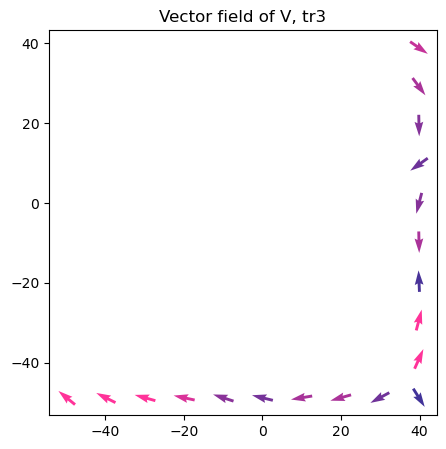

binxi -50.013
binxi -40.0104
binxi -30.0078
binxi -20.005200000000002
binxi -10.002600000000001
binxi 0.0
binxi 10.002599999999994
binxi 20.005199999999995
binxi 30.007799999999996
binxi 40.0104
[[-50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013
  -50.013  -50.013 ]
 [-40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104
  -40.0104 -40.0104]
 [-30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078
  -30.0078 -30.0078]
 [-20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052
  -20.0052 -20.0052]
 [-10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026
  -10.0026 -10.0026]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [ 10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026
   10.0026  10.0026]
 [ 20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052
   20.0052  20.0052]
 [ 30.0078  30.0078  30.0078  30.0078  30.0078  30

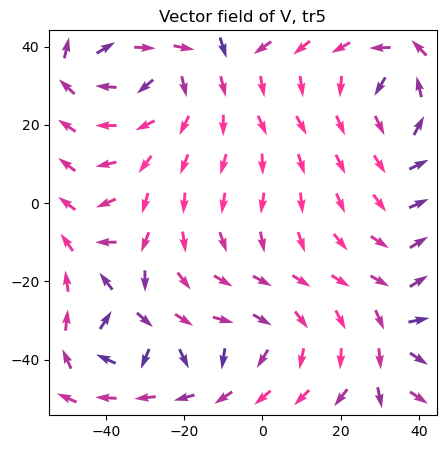

binxi -47.496
binxi -37.7693
binxi -28.042600000000004
binxi -18.315900000000006
binxi -8.589200000000005
binxi 1.1374999999999957
binxi 10.86419999999999
binxi 20.590899999999998
binxi 30.31759999999999
binxi 40.044299999999986
[[-47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496
  -47.496  -47.496 ]
 [-37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693
  -37.7693 -37.7693]
 [-28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426
  -28.0426 -28.0426]
 [-18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159
  -18.3159 -18.3159]
 [ -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892
   -8.5892  -8.5892]
 [  1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375
    1.1375   1.1375]
 [ 10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642
   10.8642  10.8642]
 [ 20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909
   20.5909  20.5909]
 [ 30.3176  

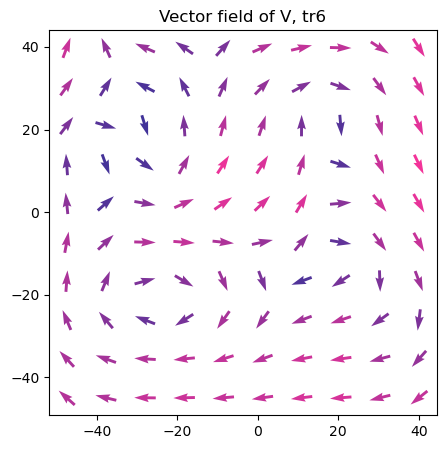

binxi -42.108000000000004
binxi -33.89790000000001
binxi -25.687800000000003
binxi -17.477700000000002
binxi -9.267600000000002
binxi -1.0575000000000045
binxi 7.1526
binxi 15.362700000000004
binxi 23.5728
binxi 31.782899999999998
[[-42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108
  -42.108  -42.108 ]
 [-33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979
  -33.8979 -33.8979]
 [-25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878
  -25.6878 -25.6878]
 [-17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777
  -17.4777 -17.4777]
 [ -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676
   -9.2676  -9.2676]
 [ -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575
   -1.0575  -1.0575]
 [  7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526
    7.1526   7.1526]
 [ 15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627
   15.3627  15.3627]
 [ 23.5728

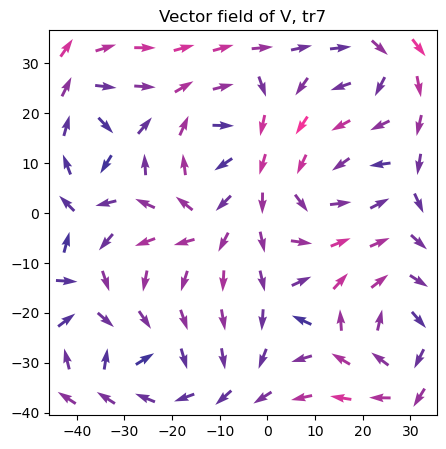

binxi -44.432
binxi -35.499700000000004
binxi -26.5674
binxi -17.635099999999998
binxi -8.702799999999996
binxi 0.2295000000000016
binxi 9.161800000000007
binxi 18.09410000000001
binxi 27.02640000000001
binxi 35.95870000000001
[[-44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432
  -44.432  -44.432 ]
 [-35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997
  -35.4997 -35.4997]
 [-26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674
  -26.5674 -26.5674]
 [-17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351
  -17.6351 -17.6351]
 [ -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028
   -8.7028  -8.7028]
 [  0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295
    0.2295   0.2295]
 [  9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618
    9.1618   9.1618]
 [ 18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941
   18.0941  18.0941]
 [ 27.0264  27

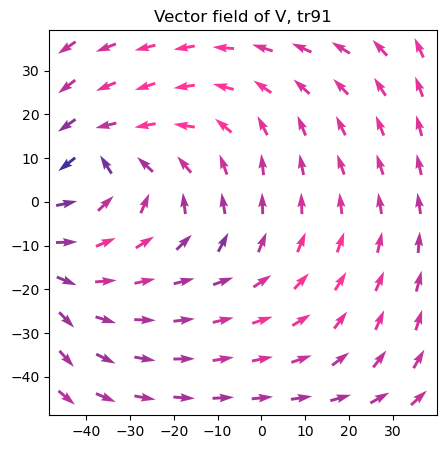

hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
binxi -49.543
binxi -39.7358
binxi -29.9286
binxi -20.1214
binxi -10.3142
binxi -0.5069999999999979
binxi 9.300199999999997
binxi 19.107400000000005
binxi 28.9146
binxi 38.721799999999995
[[-49.543  -49.543  -49.543  -49.543  -49.543  -49.543  -49.543  -49.543
  -49.543  -49.543 ]
 [-39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358 -39.7358
  -39.7358 -39.7358]
 [-29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286 -29.9286
  -29.9286 -29.9286]
 [-20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214 -20.1214
  -20.1214 -20.1214]
 [-10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142 -10.3142
  -10.3142 -10.3142]
 [ -0.507   -0.507   -0.507   -0.507   -0.507   -0.507   -0.507   -0.507
   -0.507   -0.507 ]
 [  9.3002   9.3002   9.3002   9.3002   9.3002   9.3002   9.3002   9.3002
    9.3002   9.3002]
 [ 19.1074  19.1074  19.1074  19.1074  19.1074  19.1074  19.1074  19.1074
   19.1074  19.1074]
 [ 28.9146  28.914

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


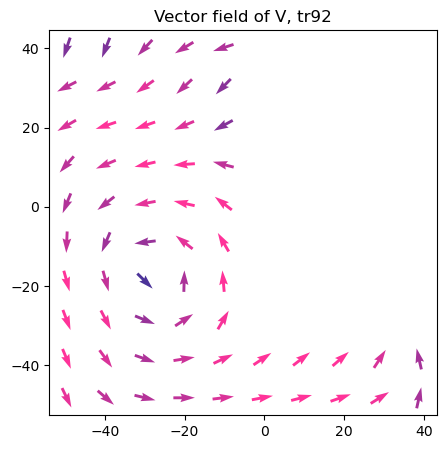

hu
hu
hu
hu
binxi -46.433
binxi -37.1464
binxi -27.8598
binxi -18.5732
binxi -9.2866
binxi 0.0
binxi 9.2866
binxi 18.573200000000007
binxi 27.8598
binxi 37.14639999999999
[[-46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433
  -46.433  -46.433 ]
 [-37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464
  -37.1464 -37.1464]
 [-27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598
  -27.8598 -27.8598]
 [-18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732
  -18.5732 -18.5732]
 [ -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866
   -9.2866  -9.2866]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866
    9.2866   9.2866]
 [ 18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732
   18.5732  18.5732]
 [ 27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598


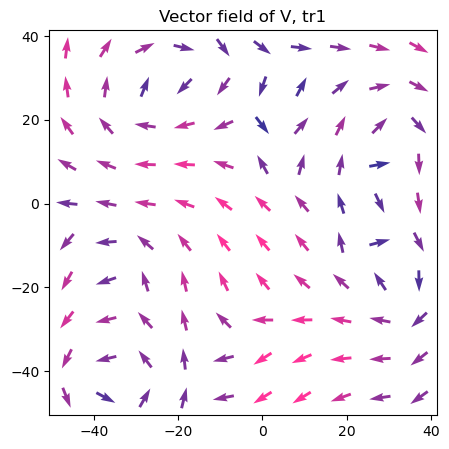

hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
binxi -23.365000000000002
binxi -18.407600000000002
binxi -13.4502
binxi -8.492799999999999
binxi -3.535399999999999
binxi 1.4220000000000006
binxi 6.379400000000004
binxi 11.336800000000004
binxi 16.294200000000004
binxi 21.251600000000003
[[-23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365
  -23.365  -23.365 ]
 [-18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076
  -18.4076 -18.4076]
 [-13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502
  -13.4502 -13.4502]
 [ -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928
   -8.4928  -8.4928]
 [ -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354
   -3.5354  -3.5354]
 [  1.422    1.422    1.422    1.422    1.422    1.422    1.422    1.422
    1.422    1.422 ]
 [  6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794
    6.3794   6.3794]
 [ 11.3368  11.3368  11.3368  11.3368  11.336

C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\matplotlib\quiver.py:661: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\Lenovo\anaconda3\envs\navigation\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


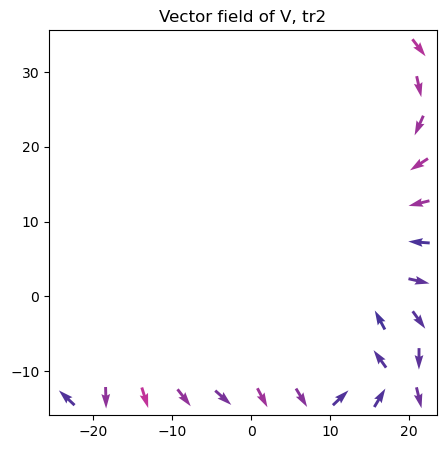

In [213]:
for i in range(1,len(dfs)):
    plotVectField(dfs[i], names[i], 10)

In [217]:
names

['tr4', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92', 'tr1', 'tr2']

binxi -50.013
binxi -40.0104
binxi -30.0078
binxi -20.005200000000002
binxi -10.002600000000001
binxi 0.0
binxi 10.002599999999994
binxi 20.005199999999995
binxi 30.007799999999996
binxi 40.0104
[[-50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013  -50.013
  -50.013  -50.013 ]
 [-40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104 -40.0104
  -40.0104 -40.0104]
 [-30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078 -30.0078
  -30.0078 -30.0078]
 [-20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052 -20.0052
  -20.0052 -20.0052]
 [-10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026 -10.0026
  -10.0026 -10.0026]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [ 10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026  10.0026
   10.0026  10.0026]
 [ 20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052  20.0052
   20.0052  20.0052]
 [ 30.0078  30.0078  30.0078  30.0078  30.0078  30

<Figure size 500x500 with 0 Axes>

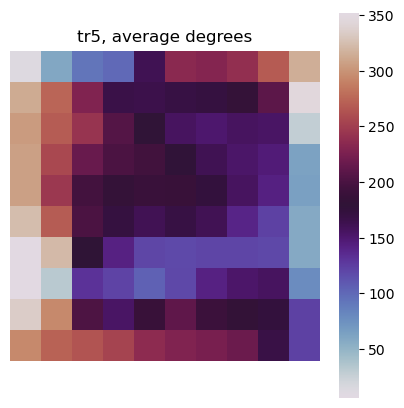

binxi -47.496
binxi -37.7693
binxi -28.042600000000004
binxi -18.315900000000006
binxi -8.589200000000005
binxi 1.1374999999999957
binxi 10.86419999999999
binxi 20.590899999999998
binxi 30.31759999999999
binxi 40.044299999999986
[[-47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496  -47.496
  -47.496  -47.496 ]
 [-37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693 -37.7693
  -37.7693 -37.7693]
 [-28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426 -28.0426
  -28.0426 -28.0426]
 [-18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159 -18.3159
  -18.3159 -18.3159]
 [ -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892  -8.5892
   -8.5892  -8.5892]
 [  1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375   1.1375
    1.1375   1.1375]
 [ 10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642  10.8642
   10.8642  10.8642]
 [ 20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909  20.5909
   20.5909  20.5909]
 [ 30.3176  

<Figure size 500x500 with 0 Axes>

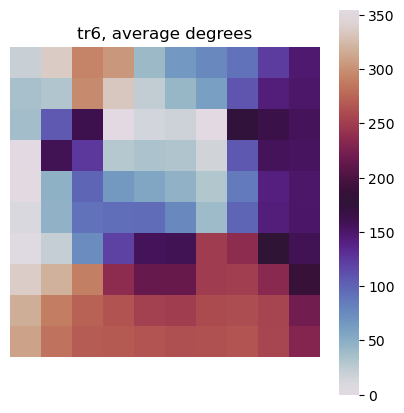

binxi -42.108000000000004
binxi -33.89790000000001
binxi -25.687800000000003
binxi -17.477700000000002
binxi -9.267600000000002
binxi -1.0575000000000045
binxi 7.1526
binxi 15.362700000000004
binxi 23.5728
binxi 31.782899999999998
[[-42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108  -42.108
  -42.108  -42.108 ]
 [-33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979 -33.8979
  -33.8979 -33.8979]
 [-25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878 -25.6878
  -25.6878 -25.6878]
 [-17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777 -17.4777
  -17.4777 -17.4777]
 [ -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676  -9.2676
   -9.2676  -9.2676]
 [ -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575  -1.0575
   -1.0575  -1.0575]
 [  7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526   7.1526
    7.1526   7.1526]
 [ 15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627  15.3627
   15.3627  15.3627]
 [ 23.5728

<Figure size 500x500 with 0 Axes>

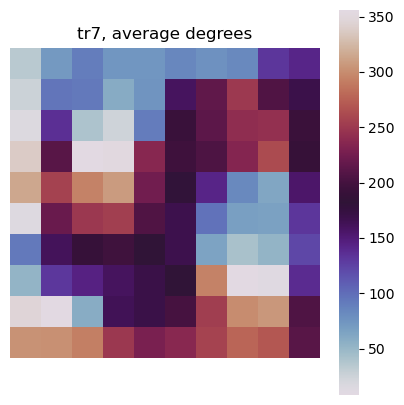

binxi -44.432
binxi -35.499700000000004
binxi -26.5674
binxi -17.635099999999998
binxi -8.702799999999996
binxi 0.2295000000000016
binxi 9.161800000000007
binxi 18.09410000000001
binxi 27.02640000000001
binxi 35.95870000000001
[[-44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432  -44.432
  -44.432  -44.432 ]
 [-35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997 -35.4997
  -35.4997 -35.4997]
 [-26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674 -26.5674
  -26.5674 -26.5674]
 [-17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351 -17.6351
  -17.6351 -17.6351]
 [ -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028  -8.7028
   -8.7028  -8.7028]
 [  0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295   0.2295
    0.2295   0.2295]
 [  9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618   9.1618
    9.1618   9.1618]
 [ 18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941  18.0941
   18.0941  18.0941]
 [ 27.0264  27

<Figure size 500x500 with 0 Axes>

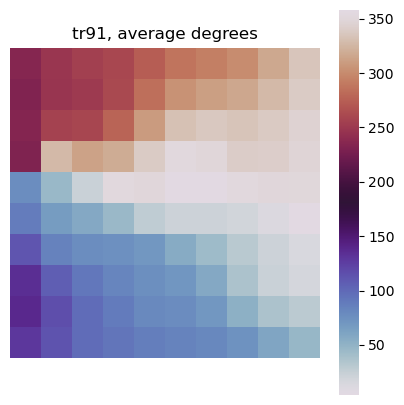

hu
hu
hu
hu
binxi -46.433
binxi -37.1464
binxi -27.8598
binxi -18.5732
binxi -9.2866
binxi 0.0
binxi 9.2866
binxi 18.573200000000007
binxi 27.8598
binxi 37.14639999999999
[[-46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433  -46.433
  -46.433  -46.433 ]
 [-37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464 -37.1464
  -37.1464 -37.1464]
 [-27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598 -27.8598
  -27.8598 -27.8598]
 [-18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732 -18.5732
  -18.5732 -18.5732]
 [ -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866  -9.2866
   -9.2866  -9.2866]
 [  0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.    ]
 [  9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866   9.2866
    9.2866   9.2866]
 [ 18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732  18.5732
   18.5732  18.5732]
 [ 27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598  27.8598


<Figure size 500x500 with 0 Axes>

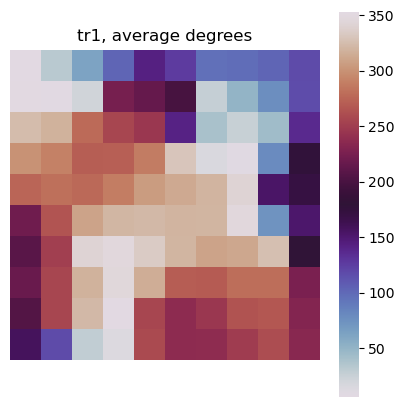

hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
hu
binxi -23.365000000000002
binxi -18.407600000000002
binxi -13.4502
binxi -8.492799999999999
binxi -3.535399999999999
binxi 1.4220000000000006
binxi 6.379400000000004
binxi 11.336800000000004
binxi 16.294200000000004
binxi 21.251600000000003
[[-23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365  -23.365
  -23.365  -23.365 ]
 [-18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076 -18.4076
  -18.4076 -18.4076]
 [-13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502 -13.4502
  -13.4502 -13.4502]
 [ -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928  -8.4928
   -8.4928  -8.4928]
 [ -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354  -3.5354
   -3.5354  -3.5354]
 [  1.422    1.422    1.422    1.422    1.422    1.422    1.422    1.422
    1.422    1.422 ]
 [  6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794   6.3794
    6.3794   6.3794]
 [ 11.3368  11.3368  11.3368  11.3368  11.336

ValueError: cannot convert float NaN to integer

<Figure size 500x500 with 0 Axes>

In [218]:
for i in [2, 3, 4, 5, 7, 8]:
    plotTurnsMap(dfs[i], names[i], 10)

In [214]:
#n=10
#df = dfs[3]
#name = names[3]
def plotTurnsMap(df,name,n):
    ind = range(0, len(df))
    df = df.reindex(ind)   
    binx = np.linspace(df["x"].min() - 0.1, df["x"].max() + 0.1, n+1)
    x_cut = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min(), df["y"].max(), n+1)
    y_cut = pd.cut(df.y, biny, right=False)
    dfn = df.groupby([x_cut, y_cut]).mean()
    z_v = pd.DataFrame(dfn.loc[:, 'V'])
    z_v = z_v.unstack()
    dfstd = df.groupby([x_cut, y_cut]).std()
    z_std = pd.DataFrame(dfstd.loc[:, 'V'])
    z_std = z_std.unstack()
    dfvx = pd.DataFrame(dfn.loc[:, 'Vx'])
    dfvx = dfvx.unstack()
    #print(dfvx)
    dfvy = pd.DataFrame(dfn.loc[:, 'Vy'])
    dfvy = dfvy.unstack()
    z_v = killnan(z_v,n)
    z_std = killnan(z_std,n)
    dfvx = killnan(dfvx,n)
    dfvy = killnan(dfvy,n)
    forVect = []
    for i in range(n):
        kk = []
        for j in range(n):
            vx = dfvx.iloc[i][j]
            vy = dfvy.iloc[i][j]
            mea = z_v.iloc[i][j]
            st = z_std.iloc[i][j]
            vx, vy = changeVect(vx, vy, mea, st)
            kk.append([binx[i],biny[j],vx,vy])
        print('binxi',binx[i])
        forVect.append(kk)
    Vectors = np.array(forVect)
    #print(pd.DataFrame(Vectors))
    print(Vectors[:, :, 0])
    #print(Vectors.shape)
    plt.figure(figsize=(5,5))
    vectx = Vectors[:,:,2]
    vecty = Vectors[:,:,3]
    vectx = gaussian_filter(vectx, sigma=1)
    vecty = gaussian_filter(vecty, sigma=1)
    

    arct = np.empty(shape=(n, n), dtype=int)
    for i in range(n):
            #попробуем реверсд ранге чтобы не было проблем с тем что ось ч на хитмапе напривлена вниз
            #for j in reversed(range(n)):
            for j in range(n):
                vx = vectx[i][j]
                vy = vecty[i][j]
                x = vy/vx
                if vx >= 0:
                    res = math.degrees(math.atan(x))
                else:
                    res = 180 + math.degrees(math.atan(x))
                if res <= 0:
                    res = -res + 90
                elif res > 0:
                    res = 360 - res + 90
                if res >= 360:
                    res -= 360
                
                arct[i][j] = res
                #arct[j][i] = res
    plt.figure(figsize=(5,5))
    #plt.figure(figsize=(4,4))
    arct = np.rot90(arct)
    sns.heatmap(arct,cmap='twilight',square=True,xticklabels=False, yticklabels=False)
    #sns.heatmap(arct,cmap='twilight',square=True).invert_yaxis()
    #plt.pcolormesh(arct)
    plt.title(name + ', average degrees')
    #plt.savefig('C:\\Users\\Lenovo\\1navigation\\vectFields\\filtered\\векторнКартаЦвета\\' + name + 'NewVelocityField.png')
    plt.show()
    #print('arct',arct)
    return arct